Suggestion for virtual enviroment:
----------------------------------

(Not all are requirements for pymoode)

ipykernel\
jupyter\
matplotlib==3.5.* \
numpy==1.22.* \
scikit-learn==1.0.* \
scipy==1.8.* \
pymoo==0.5.* \
pymoode==0.1.* \
PyQt5==5.15.* \
pyrecorder==0.2.* 

# Import packages

In [1]:
#Useful packages
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Problem classes
from pymoo.core.problem import Problem, ElementwiseProblem
from pymoo.problems.functional import FunctionalProblem
from pymoo.optimize import minimize

In [3]:
#Algorithmss
from pymoode.algorithms import DE
from pymoode.algorithms import GDE3
from pymoode.algorithms import NSDE
from pymoode.algorithms import NSDER
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3

#Reference directions and test problems
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions

#Survival operators
from pymoode.survival import RankAndCrowding, ConstrRankAndCrowding

In [4]:
#Termination
from pymoo.termination.default import DefaultSingleObjectiveTermination, DefaultMultiObjectiveTermination

In [34]:
#Performance
from pymoo.indicators.hv import HV
from pymoode.performance import SpacingIndicator

In [6]:
#Recorder
from pyrecorder.recorder import Recorder
from pyrecorder.writers.video import Video
from pyrecorder.writers.gif import GIF
from pyrecorder.converters.matplotlib import Matplotlib

# Defining a problem

**Rastrigin:**

$f(\boldsymbol{x}) = An + \sum_{i=1}^{n}[x_i^2 - A \, \mathrm{cos}(2 \pi x_i)]$

In [7]:
#Defining the objective function
def rastrigin(x):
    return np.sum(x * x - 10 * np.cos(2 * np.pi * x)) + 10 * np.size(x)

#Functional
functional_problem_1 = FunctionalProblem(n_var=2, objs=rastrigin,
                                         xl=np.full(2, -5.12), xu=np.full(2, 5.12),
                                         constr_ieq=[])

class ElementwiseF1(ElementwiseProblem):

    def __init__(self):
        
        xl = np.full(2, -5.12)
        xu = np.full(2, 5.12)

        super().__init__(n_var=2, n_obj=1, n_constr=0, xl=xl, xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = rastrigin(x)

class ProblemF1(Problem):

    def __init__(self):
        
        xl = np.full(2, -5.12)
        xu = np.full(2, 5.12)

        super().__init__(n_var=2, n_obj=1, n_constr=0, xl=xl, xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):
        
        out["F"] = np.sum(x * x - 10 * np.cos(2 * np.pi * x), axis=1) + 10 * x.shape[1]

# Single-objective DE

In [8]:
de = DE(pop_size=30, variant="DE/rand/1/bin", F=(0.3, 1.0), CR=0.5)

In [9]:
NGEN = 100
SEED = 12

In [14]:
termination_1 = DefaultSingleObjectiveTermination(
    xtol=1e-8,
    cvtol=0.0,
    ftol=1e-8,
    period=20,
    n_max_gen=NGEN)

In [15]:
%%time
res_de_functional_1 = minimize(
    functional_problem_1,
    de,
    termination=termination_1,
    seed=SEED,
    save_history=True,
    verbose=False
)

print(f"f: {(res_de_functional_1.F[0]):.4f}")
print(f"x_opt: {(res_de_functional_1.X)}")

f: 0.0000
x_opt: [ 1.90172541e-04 -2.75540458e-05]
CPU times: total: 375 ms
Wall time: 461 ms


In [16]:
%%time
res_de_elementwise_1 = minimize(
    ElementwiseF1(),
    de,
    termination=termination_1,
    seed=SEED,
    save_history=True,
    verbose=False
)

print(f"f: {(res_de_elementwise_1.F[0]):.4f}")
print(f"x_opt: {(res_de_elementwise_1.X)}")

f: 0.0000
x_opt: [ 1.90172541e-04 -2.75540458e-05]
CPU times: total: 297 ms
Wall time: 407 ms


In [17]:
%%time
res_de_problem_1 = minimize(
    ProblemF1(),
    de,
    termination=termination_1,
    seed=SEED,
    save_history=True,
    verbose=False
)

print(f"f: {(res_de_problem_1.F[0]):.4f}")
print(f"x_opt: {(res_de_problem_1.X)}")

f: 0.0000
x_opt: [ 1.90172541e-04 -2.75540458e-05]
CPU times: total: 328 ms
Wall time: 382 ms


In [18]:
#Creating a countouf plot
x1 = np.linspace(-5.12, 5.12, 100)
x2 = np.linspace(-5.12, 5.12, 100)
X1, X2 = np.meshgrid(x1, x2)
X = np.vstack((X1.flatten().reshape([1, -1]), X2.flatten().reshape([1, -1])))
F = np.array([rastrigin(x) for x in X.T])
F = F.reshape([100, 100])

In [19]:
def make_ordinal(n):
    n = int(n)
    suffix = ['th', 'st', 'nd', 'rd', 'th'][min(n % 10, 4)]
    if 11 <= (n % 100) <= 13:
        suffix = 'th'
    return str(n) + suffix

In [20]:
writer = GIF("../images/soo_video.gif", duration=0.3)

with Recorder(writer, converter=Matplotlib(dpi=100)) as rec:
    
    for g in range(min(50, len(res_de_functional_1.history))):

        fig, ax = plt.subplots(figsize=[6, 5], dpi=150)
        
        fig.patch.set_facecolor('white')

        surf = ax.contourf(X1, X2, F, levels=40)
        fig.colorbar(surf, shrink=1.0, aspect=20)

        ax.scatter(res_de_functional_1.history[g].pop.get("X")[:, 0],
                   res_de_functional_1.history[g].pop.get("X")[:, 1],
                   marker="x", color="red", label="Population")
        ax.legend(framealpha=1.0)

        ax.set_xlabel("$x_1$")
        ax.set_ylabel("$x_2$")
        
        _text = make_ordinal(g + 1)
        
        plt.text(0.1, 0.1, f"{_text} gen", transform=plt.gca().transAxes,
                 bbox=dict(facecolor='white', edgecolor='black'))

        plt.tight_layout()
        
        rec.record()

# Multi-objective problem

$f_1(\boldsymbol{x}) = (x_1 - 0.5) ^ 2 + 0.7 x_1 x_2 + 1.2 (x_2 + 0.7) ^ 2$

$f_2(\boldsymbol{x}) = (x_1 + 1.5) ^ 2 + 0.8 x_1 x_2 + 1.3 (x_2 - 1.7) ^ 2$

$g_1(\boldsymbol{x}) \equiv x_1 ^ 2 + (x_2 - 1) ^ 2 - 9 \leq 0$

$g_2(\boldsymbol{x}) \equiv - (x_1 + 0.5) ^ 2 - (x_2 - 1) ^ 2 + 2 \leq 0$

In [21]:
class ProblemF2(Problem):

    def __init__(self):
        
        xl = np.full(2, -5.0)
        xu = np.full(2, 5.0)

        super().__init__(n_var=2, n_obj=2, n_constr=2, xl=xl, xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):
        
        F1 = (x[:, 0] - 0.5) ** 2 + 0.7 * x[:, 0] * x[:, 1] + 1.2 * (x[:, 1] + 0.7) ** 2
        
        F2 = 1.1 * (x[:, 0] + 1.5) ** 2 + 0.8 * x[:, 0] * x[:, 1] + 1.3 * (x[:, 1] - 1.7) ** 2
        
        out["F"] = np.column_stack([F1, F2])
        
        G1 = x[:, 0] ** 2 + (x[:, 1] - 1) ** 2 - 9
        G2 = - (x[:, 0] + 0.5) ** 2 - (x[:, 1] - 1) ** 2 + 2
        
        out["G"] = np.column_stack([G1, G2])

In [22]:
#Using a not so large value for CR due to the low dimensionality of the problem
gde3 = GDE3(pop_size=50, variant="DE/rand/1/bin", F=(0.0, 1.0), CR=0.7)
nsde = NSDE(pop_size=50, variant="DE/rand/1/bin", F=(0.0, 1.0), CR=0.7)
nsga2 = NSGA2(pop_size=50)

In [23]:
%matplotlib inline

In [24]:
NGEN = 200

In [25]:
termination_multi = DefaultMultiObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-8,
    ftol=1e-8,
    period=50,
    n_max_gen=NGEN,
)

In [26]:
res_gde3_problem_2 = minimize(
    ProblemF2(),
    gde3,
    termination_multi,
    seed=SEED,
    save_history=True,
    verbose=False
)

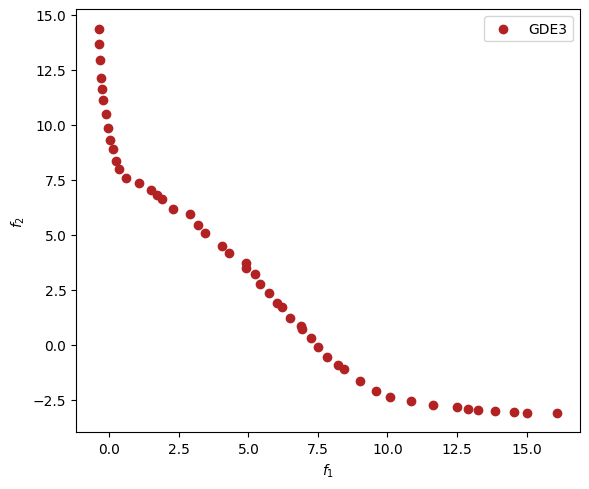

In [27]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)
ax.scatter(res_gde3_problem_2.F[:, 0], res_gde3_problem_2.F[:, 1], color="firebrick", label="GDE3")
ax.set_ylabel("$f_2$")
ax.set_xlabel("$f_1$")
ax.legend()
fig.tight_layout()
plt.show()

In [28]:
res_nsde_problem_2 = minimize(
    ProblemF2(),
    nsde,
    termination_multi,
    seed=SEED,
    save_history=True,
    verbose=False
)

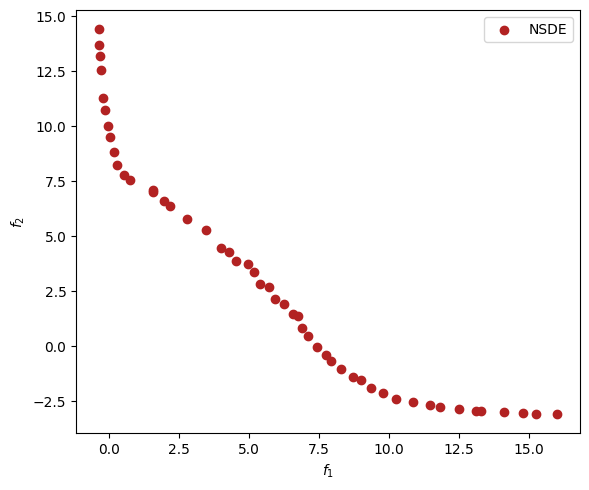

In [29]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)
ax.scatter(res_nsde_problem_2.F[:, 0], res_nsde_problem_2.F[:, 1], color="firebrick", label="NSDE")
ax.set_ylabel("$f_2$")
ax.set_xlabel("$f_1$")
ax.legend()
fig.tight_layout()
plt.show()

In [30]:
res_nsga2_problem_2 = minimize(
    ProblemF2(),
    nsga2,
    termination_multi,
    seed=SEED,
    save_history=True,
    verbose=False
)

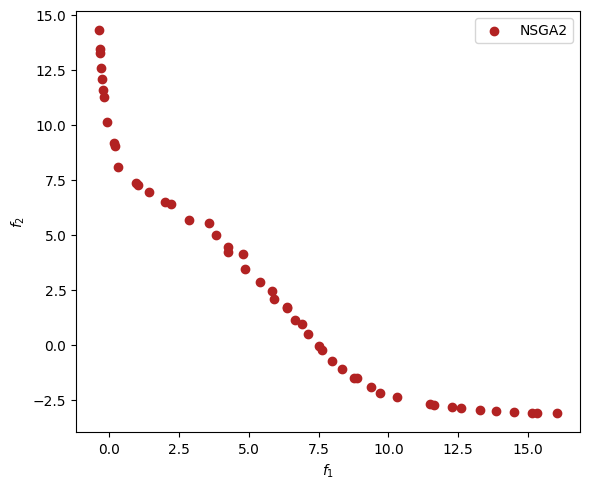

In [31]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)
ax.scatter(res_nsga2_problem_2.F[:, 0], res_nsga2_problem_2.F[:, 1], color="firebrick", label="NSGA2")
ax.set_ylabel("$f_2$")
ax.set_xlabel("$f_1$")
ax.legend()
fig.tight_layout()
plt.show()

In [32]:
objs_p2 = np.row_stack([res_nsde_problem_2.F, res_gde3_problem_2.F, res_nsga2_problem_2.F])
nadir_p2 = objs_p2.max(axis=0)
reference_p2 = nadir_p2 + 1e-6
ideal_p2 =  objs_p2.min(axis=0)

In [35]:
#Evaluate by Hypervolume
hv_p2 = HV(zero_to_one=True, ref_point=reference_p2, nadir=nadir_p2, ideal=ideal_p2)

print("hv GDE3", hv_p2.do(res_gde3_problem_2.F))
print("hv NSDE", hv_p2.do(res_nsde_problem_2.F))
print("hv NSGA-II", hv_p2.do(res_nsga2_problem_2.F))

hv GDE3 0.7534718209265902
hv NSDE 0.7522736340092664
hv NSGA-II 0.7503122724585839


## Record evolution on multi-objective problems

In [36]:
writer = GIF("../images/moo_gde3_f_video.gif", duration=0.3)

with Recorder(writer, converter=Matplotlib(dpi=100)) as rec:
    
    for g in range(min(70, len(res_gde3_problem_2.history))):

        fig, ax = plt.subplots(figsize=[6, 5], dpi=150)
        
        fig.patch.set_facecolor('white')
        
        ranks = res_gde3_problem_2.history[g].pop.get("rank")
        front = ranks == 0
        
        cv = res_gde3_problem_2.history[g].pop.get("CV").flatten()
        infeasible = cv > 0.0

        ax.scatter(res_gde3_problem_2.history[g].pop.get("F")[front, 0],
                   res_gde3_problem_2.history[g].pop.get("F")[front, 1],
                   marker="o", color="black", label="Pareto front")
        
        ax.scatter(res_gde3_problem_2.history[g].pop.get("F")[~(front | infeasible), 0],
                   res_gde3_problem_2.history[g].pop.get("F")[~(front | infeasible), 1],
                   marker="x", color="grey", label="Dominated")
        
        ax.scatter(res_gde3_problem_2.history[g].pop.get("F")[infeasible, 0],
                   res_gde3_problem_2.history[g].pop.get("F")[infeasible, 1],
                   marker="x", color="firebrick", label="Infeasible")
        
        ax.legend(framealpha=1.0, loc="upper right")

        ax.set_xlabel("$f_1$")
        ax.set_ylabel("$f_2$")
        
        _text = make_ordinal(g + 1)
        
        plt.text(0.1, 0.1, f"{_text} gen", transform=plt.gca().transAxes,
                 bbox=dict(facecolor='white', edgecolor='black'))
        
        ax.set_ylim([-4.0, 17])
        ax.set_xlim([-1.0, 17])

        plt.tight_layout()
        
        rec.record()

In [37]:
writer = GIF("../images/moo_gde3_x_video.gif", duration=0.3)

with Recorder(writer, converter=Matplotlib(dpi=100)) as rec:
    
    for g in range(min(70, len(res_gde3_problem_2.history))):

        fig, ax = plt.subplots(figsize=[6, 5], dpi=150)
        
        fig.patch.set_facecolor('white')
        
        ranks = res_gde3_problem_2.history[g].pop.get("rank")
        front = ranks == 0
        
        cv = res_gde3_problem_2.history[g].pop.get("CV").flatten()
        infeasible = cv > 0.0

        ax.scatter(res_gde3_problem_2.history[g].pop.get("X")[front, 0],
                   res_gde3_problem_2.history[g].pop.get("X")[front, 1],
                   marker="o", color="black", label="Pareto front")
        
        ax.scatter(res_gde3_problem_2.history[g].pop.get("X")[~(front | infeasible), 0],
                   res_gde3_problem_2.history[g].pop.get("X")[~(front | infeasible), 1],
                   marker="x", color="grey", label="Dominated")
        
        ax.scatter(res_gde3_problem_2.history[g].pop.get("X")[infeasible, 0],
                   res_gde3_problem_2.history[g].pop.get("X")[infeasible, 1],
                   marker="x", color="firebrick", label="Infeasible")
        
        ax.legend(framealpha=1.0, loc="upper right")

        ax.set_xlabel("$x_1$")
        ax.set_ylabel("$x_2$")
        
        _text = make_ordinal(g + 1)
        
        plt.text(0.1, 0.1, f"{_text} gen", transform=plt.gca().transAxes,
                 bbox=dict(facecolor='white', edgecolor='black'))
        
        ax.set_ylim([-5, 5])
        ax.set_xlim([-5, 5])

        plt.tight_layout()
        
        rec.record()

## Pruning crowding distances

In [38]:
pruning_survival = RankAndCrowding(crowding_func="pcd")

In [39]:
gde3_ps = GDE3(pop_size=50, variant="DE/rand/1/bin", F=(0.0, 1.0), CR=0.7, survival=pruning_survival)

In [40]:
res_gde3_ps_problem_2 = minimize(
    ProblemF2(),
    gde3_ps,
    ('n_gen', NGEN),
    seed=SEED,
    save_history=True,
    verbose=False
)

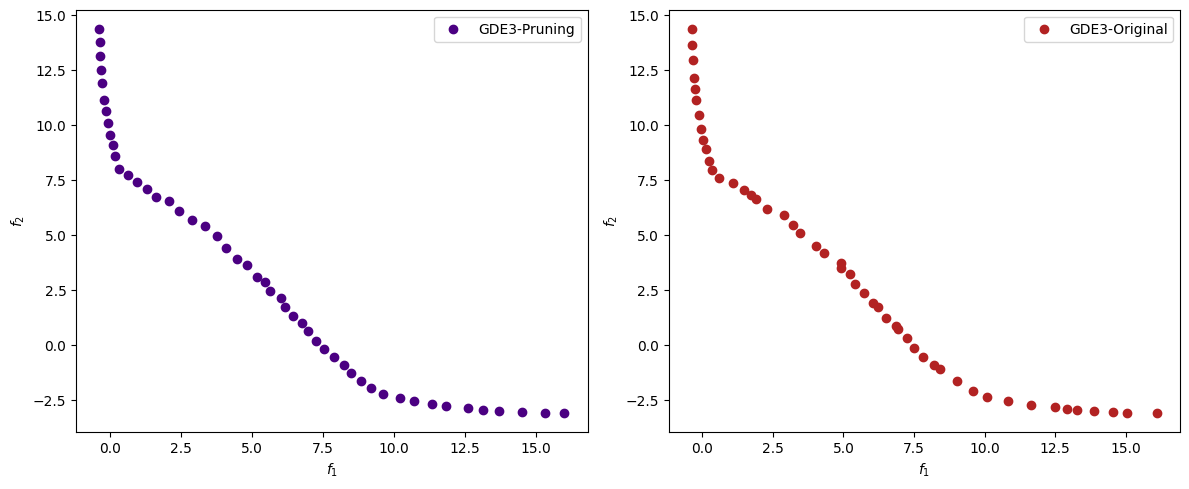

In [41]:
fig, ax = plt.subplots(1, 2, figsize=[12, 5], dpi=100)

ax[0].scatter(res_gde3_ps_problem_2.F[:, 0], res_gde3_ps_problem_2.F[:, 1], color="indigo", label="GDE3-Pruning", marker="o")
ax[0].set_ylabel("$f_2$")
ax[0].set_xlabel("$f_1$")
ax[0].legend()

ax[1].scatter(res_gde3_problem_2.F[:, 0], res_gde3_problem_2.F[:, 1], color="firebrick", label="GDE3-Original", marker="o")
ax[1].set_ylabel("$f_2$")
ax[1].set_xlabel("$f_1$")
ax[1].legend()

fig.tight_layout()
plt.show()

In [42]:
print("hv GDE3", hv_p2.do(res_gde3_problem_2.F))
print("hv GDE3-PS", hv_p2.do(res_gde3_ps_problem_2.F))

hv GDE3 0.7534718209265902
hv GDE3-PS 0.7551582955337576


In [43]:
ideal = np.vstack((res_gde3_problem_2.F, res_gde3_ps_problem_2.F)).min(axis=0) - 1e-3
nadir = np.vstack((res_gde3_problem_2.F, res_gde3_ps_problem_2.F)).max(axis=0) + 1e-3

sp_p2 = SpacingIndicator(
    zero_to_one=True,
    ideal=ideal,
    nadir=nadir
)

In [44]:
print("SP GDE3", sp_p2.do(res_gde3_problem_2.F))
print("SP GDE3-PS", sp_p2.do(res_gde3_ps_problem_2.F))

SP GDE3 0.012024880243150753
SP GDE3-PS 0.004881671664926163


# Many-objective problem

In [45]:
#Define the reference directions
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=15)

#Suggestion for NSGA-III
popsize = ref_dirs.shape[0] + ref_dirs.shape[0] % 4

gde3mnn = GDE3(pop_size=popsize, variant="DE/rand/1/bin", F=(0.0, 1.0), CR=0.2,
               survival=RankAndCrowding(crowding_func="mnn"))

nsder = NSDER(ref_dirs, pop_size=popsize, variant="DE/rand/1/bin", F=(0.0, 1.0), CR=0.5)

nsga3 = NSGA3(ref_dirs, pop_size=popsize)

**DTLZ2:**

$f_1(\boldsymbol{x}) = \mathrm{cos}(\pi / 2 x_1) \, \mathrm{cos}(\pi / 2 x_2) (1 + g(\boldsymbol{x}))$

$f_2(\boldsymbol{x}) = \mathrm{cos}(\pi / 2 x_1) \, \mathrm{sin}(\pi / 2 x_2) (1 + g(\boldsymbol{x}))$

$f_3(\boldsymbol{x}) = \mathrm{sin}(\pi / 2 x_1) (1 + g(\boldsymbol{x}))$

$g(\boldsymbol{x}) = \sum_{i=1}^{3}(x_i - 0.5) ^ 2$

In [46]:
%%time

res_nsder_problem_3 = minimize(
    get_problem("dtlz2"),
    nsder,
    ('n_gen', 250),
    seed=SEED,
    save_history=True,
    verbose=False
)

CPU times: total: 7.94 s
Wall time: 8.19 s


In [47]:
%%time

res_gde3_problem_3 = minimize(
    get_problem("dtlz2"),
    gde3mnn,
    ('n_gen', 250),
    seed=SEED,
    save_history=True,
    verbose=False
)

CPU times: total: 7.3 s
Wall time: 7.45 s


In [48]:
%%time

res_nsga3_problem_3 = minimize(
    get_problem("dtlz2"),
    nsga3,
    ('n_gen', 250),
    seed=SEED,
    save_history=True,
    verbose=False
)

CPU times: total: 8.8 s
Wall time: 9.08 s


In [64]:
#%matplotlib qt

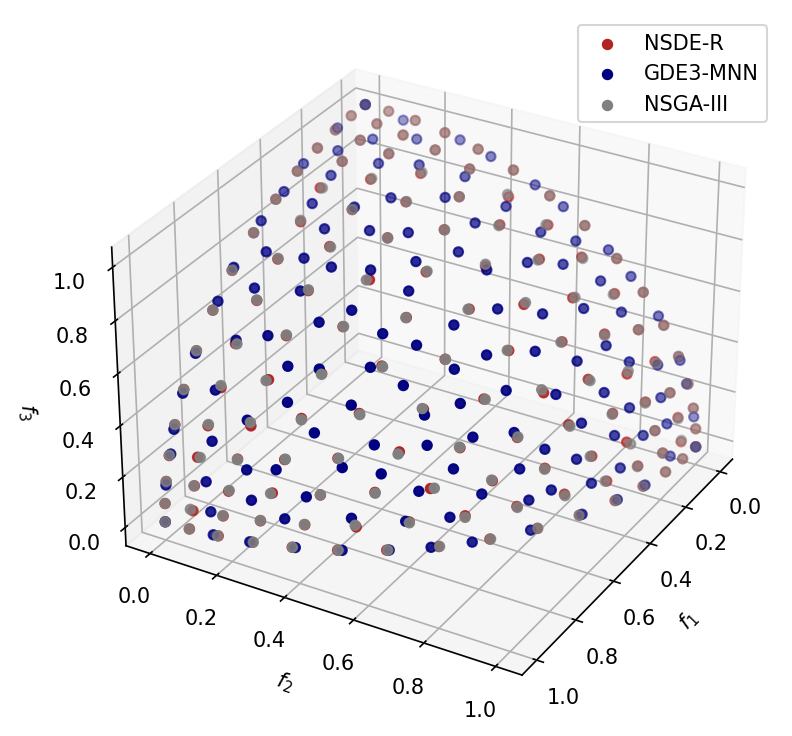

In [49]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150, subplot_kw={'projection':'3d'})

ax.scatter(res_nsder_problem_3.F[:, 0], res_nsder_problem_3.F[:, 1], res_nsder_problem_3.F[:, 2],
        color="firebrick", label="NSDE-R", marker="o")

ax.scatter(res_gde3_problem_3.F[:, 0], res_gde3_problem_3.F[:, 1], res_gde3_problem_3.F[:, 2],
        color="navy", label="GDE3-MNN", marker="o")

ax.scatter(res_nsga3_problem_3.F[:, 0], res_nsga3_problem_3.F[:, 1], res_nsga3_problem_3.F[:, 2],
        color="grey", label="NSGA-III", marker="o")

ax.view_init(elev=30, azim=30)

ax.set_xlabel("$f_1$")
ax.set_ylabel("$f_2$")
ax.set_zlabel("$f_3$")
ax.legend()
fig.tight_layout()

In [50]:
writer = GIF("../images/3d_many_obj_video.gif", duration=0.1)

with Recorder(writer, converter=Matplotlib(dpi=100)) as rec:

    for azim in np.linspace(30, 390, 120):
        
        fig, ax = plt.subplots(figsize=[6, 5], dpi=150, subplot_kw={'projection':'3d'})
        
        fig.patch.set_facecolor('white')
        
        ax.scatter(res_nsder_problem_3.F[:, 0], res_nsder_problem_3.F[:, 1], res_nsder_problem_3.F[:, 2],
                color="firebrick", label="NSDE-R", marker="o")
        
        ax.scatter(res_gde3_problem_3.F[:, 0], res_gde3_problem_3.F[:, 1], res_gde3_problem_3.F[:, 2],
                color="navy", label="GDE3-MNN", marker="o")

        ax.scatter(res_nsga3_problem_3.F[:, 0], res_nsga3_problem_3.F[:, 1], res_nsga3_problem_3.F[:, 2],
                color="grey", label="NSGA-III", marker="o")
        
        ax.view_init(elev=25, azim=azim)

        ax.set_xlabel("$f_1$")
        ax.set_ylabel("$f_2$")
        ax.set_zlabel("$f_3$")
        ax.legend()
        fig.tight_layout()
        
        rec.record()

AttributeError: module 'pymoode' has no attribute '__version__'